# Processing dataset and creation of Dataloaders

In [14]:
# Import standard libraries
import sys, os, shutil, time
from pathlib import Path
# For audio and MIDI processing
import pretty_midi
import IPython
# For numerical processing
import numpy as np
import torch
# For parallel processing
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
# For statistical analysis
from collections import Counter
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# For data splitting
from sklearn.model_selection import train_test_split

# Import this project modules
REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from src.data.dataset import PianoMmapDataset, MidiPreprocessor, create_mmap_dataset
from src.utils.visualization import display_prettymidi
from src.utils.tools import piano_roll_to_pretty_midi

## Pretty_midi --> matrix (parallel processing for whole dataset)

Poichè trasformare un file midi in una matrice non è computazionalmente semplice se bisogna farlo su migliaia di file, conviene preprocessare prima del training ogni file midi e salvare i risultati in una cartella.
Per rendere il processo ancora più efficiente questo procedimento viene eseguito in parallelo su tutti i core disponibili della cpu.
Al momento quello che viene fatto è:

1. da ciascun file MIDI vengono separate le tracce al piano
2. viene suddiviso in sezioni a bpm costante
3. per ciascuna di queste viene estratto un piano-roll
4. il piano roll viene segmentato in porzioni di lunghezza 128 battiti che corrispondono a 8 bars in 4/4

Ogni segmento viene salvato in una versione sparsa e compattata in un file .npz.
Per modificare il preprocessing modificare `MidiPreprocessor`.

In seguito viene realizzato un memory mapping su disco. 
E' un metodo molto efficiente per importare dati in memoria quando non si ha abbastanza spazio in RAM, questo rende il caricamento dei piano roll velocissimo.

In [15]:
clean_midi_path = REPO_ROOT / 'data' / 'prove'
npz_path = REPO_ROOT / 'data' / 'processed_npz'
mmap_path = REPO_ROOT / 'data' / 'piano_dataset.dat'
processing_results_path = REPO_ROOT / 'data' / 'processing_results_details.txt'
segments_details_path = REPO_ROOT / 'data' / 'segments_metadata.txt'

# Solves problem "Adventures of Stevie V." (path with final dot)
if os.name == 'nt':
    clean_midi_path = Path(f"\\\\?\\{str(clean_midi_path.resolve())}")

# Get list of all MIDI files
midi_files = list(clean_midi_path.rglob('*.mid'))

selected_instruments = range(8)  # Piano and related instruments

Questa cella si può saltare se il preprocessing è già stato fatto.

In [16]:
# Clean the whole directory
shutil.rmtree(npz_path)
npz_path.mkdir(parents=True, exist_ok=True)
(npz_path / '.gitkeep').touch()

# Initialize Stats
valid_source_files = 0
total_segments = 0
error_counts = Counter()
detailed_errors = []

# Initialize Processor
processor = MidiPreprocessor(
    select_instruments=selected_instruments, 
    note_start=24, 
    note_end=84, 
    output_dir=npz_path,
    min_notes=20,
    min_polyphony=1.0
)

print(f"Starting preprocessing. Metadata will be written in real-time to: {segments_details_path}")

# --- CORE LOGIC ---
with open(segments_details_path, 'w') as f_meta:
    # Write the header
    f_meta.write("filename\tinstrument\tfs\tbpm\n")

    # Start the process Pool
    with Pool(processes=cpu_count()) as pool:
        
        # process files in parallel with imap_unordered for streaming results
        iterator = pool.imap_unordered(processor, midi_files, chunksize=10)
        for result in tqdm(iterator, total=len(midi_files), desc="Processing & Streaming", ncols=150):

            # Positive result analysis
            if isinstance(result, list):
                valid_source_files += 1
                total_segments += len(result)
                # Immediate writing to disk
                for seg in result:
                    f_meta.write(f"{seg['filename']}\t{seg['instrument']}\t{seg['fs']:.2f}\t{seg['bpm']:.2f}\n")
            # Error storage
            elif isinstance(result, str):
                if result.startswith("ERROR"):
                    error_counts["Exception"] += 1
                    detailed_errors.append(result)
                elif result.startswith("DISCARDED"):
                    if "NO PIANO" in result:
                        error_counts["No Piano"] += 1
                    elif "NO VALID SEGMENTS" in result:
                        error_counts["Segment Invalid"] += 1
                    else:
                        error_counts["Other Discard"] += 1

# Save results and stats
with open(processing_results_path, 'w') as f:
    f.write("="*50 + "\n")
    f.write(f"{'REPORT PREPROCESSING':^50}" + "\n")
    f.write("="*50 + "\n\n")

    f.write(f"{'Total files processed:':<35}{len(midi_files):>15}\n")
    f.write(f"{'Of which valid source files:':<35}{valid_source_files:>15}\n")
    f.write(f"{'Discarded files (No Piano):':<35}{error_counts['No Piano']:>15}\n")
    f.write(f"{'Discarded files (Invalid Segments):':<35}{error_counts['Segment Invalid']:>15}\n")
    f.write(f"{'Errors (Exceptions):':<35}{error_counts['Exception']:>15}\n\n")
    f.write(f"{'Total segments created:':<35}{total_segments:>15}\n\n")

    f.write(f"{' Error Details ':=^50}" + "\n\n")
    for error in detailed_errors:
        f.write(error + "\n")

# Consolidate all .npz files into a single memory-mapped dataset
create_mmap_dataset(npz_path, mmap_path)

Starting preprocessing. Metadata will be written in real-time to: /Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/data/segments_metadata.txt


Processing & Streaming:   0%|                                                                                                 | 0/441 [00:00<?, ?it/s]

Processing Foreigner__Hot_Blooded.1: Found 0 piano instruments.
Processing Foreigner__Double_Vision: Found 0 piano instruments.
Processing Foreigner__Head_Games: Found 0 piano instruments.
Processing Foreigner__Blue_Morning,_Blue_Day: Found 1 piano instruments.


/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.

Processing Foreigner__Cold_as_Ice.1: Found 1 piano instruments.
Processing Olivia_Newton-John__Xanadu.2: Found 1 piano instruments.
Processing Oasis__Don't_Look_Back_in_Anger.1: Found 15 piano instruments.
Processing Norman_Blake__John_Hardy: Found 0 piano instruments.
Processing Foreigner__Double_Vision.2: Found 0 piano instruments.
Processing Foreigner__Head_Games.1: Found 0 piano instruments.
Processing Oasis__Supersonic: Found 0 piano instruments.
Processing Foreigner__Urgent.1: Found 0 piano instruments.


/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Foreigner__Hot_Blooded: Found 1 piano instruments.
Processing Dirotta_su_Cuba__Liberi_di_-_liberi_da.1: Found 2 piano instruments.
Processing Foreigner__That_Was_Yesterday: Found 1 piano instruments.
Processing Oasis__Whatever.1: Found 1 piano instruments.
Processing Foreigner__I_Want_to_Know_What_Love_Is: Found 0 piano instruments.
Processing Foreigner__Double_Vision.1: Found 0 piano instruments.
Processing Olivia_Newton-John__Summer_Nights: Found 1 piano instruments.
Processing Foreigner__I_Want_to_Know_What_Love_Is.2: Found 0 piano instruments.
Processing Foreigner__Cold_as_Ice.3: Found 2 piano instruments.
Processing Oasis__Don't_Look_Back_in_Anger: Found 1 piano instruments.
Processing Oasis__Stand_by_Me.1: Found 1 piano instruments.
Processing Foreigner__I_Want_to_Know_What_Love_Is.1: Found 3 piano instruments.
Processing Foreigner__Urgent.3: Found 0 piano instruments.
Processing Foreigner__Waiting_for_a_Girl_Like_You.3: Found 3 piano instruments.
Processing Olivia_New

Processing & Streaming:   0%|▏                                                                                    | 1/441 [02:20<17:07:29, 140.11s/it]

Processing Foreigner__Cold_as_Ice.2: Found 2 piano instruments.
Processing Foreigner__Urgent.2: Found 0 piano instruments.
Processing Olivia_Newton-John__Xanadu.1: Found 1 piano instruments.
Processing Oasis__All_Around_the_World: Found 0 piano instruments.
Processing Foreigner__Waiting_for_a_Girl_Like_You: Found 6 piano instruments.
Processing Foreigner__Waiting_for_a_Girl_Like_You.1: Found 6 piano instruments.
Processing Oasis__Morning_Glory: Found 0 piano instruments.
Processing Oasis__Roll_With_It.1: Found 0 piano instruments.
Processing Olivia_Newton-John__Let_Me_Be_There: Found 3 piano instruments.
Processing Oasis__Champagne_Supernova: Found 2 piano instruments.
Processing Oasis__Don't_Go_Away.1: Found 0 piano instruments.
Processing Dirotta_su_Cuba__Liberi_di_-_liberi_da: Found 2 piano instruments.
Processing Olivia_Newton-John__Have_You_Ever_Been_Mellow.2: Found 1 piano instruments.
Processing Olivia_Newton-John__I_Love_You,_I_Honestly_Love_You.1: Found 3 piano instruments.
Pr

Processing & Streaming:   2%|██▏                                                                                   | 11/441 [02:20<1:06:14,  9.24s/it]

Processing Olivia_Newton-John__Xanadu: Found 1 piano instruments.
Processing Dirotta_su_Cuba__Dentro_ad_ogni_attimo: Found 2 piano instruments.
Processing Oasis__Champagne_Supernova.1: Found 2 piano instruments.
Processing Olivia_Newton-John__Summer_Nights.1: Found 0 piano instruments.
Processing Olivia_Newton-John__I_Love_You,_I_Honestly_Love_You.2: Found 3 piano instruments.
Processing Olivia_Newton-John__Banks_of_the_Ohio.1: Found 3 piano instruments.
Processing Oasis__Cast_No_Shadow: Found 3 piano instruments.
Processing Foreigner__Urgent: Found 0 piano instruments.
Processing Oasis__Do_You_Know_What_I_Mean?: Found 1 piano instruments.
Processing Alexander_O'Neal__Criticize: Found 1 piano instruments.
Processing Oasis__Do_You_Know_What_I_Mean?.1: Found 1 piano instruments.
Processing Tommy_Flanagan__I_Can't_Get_Started: Found 1 piano instruments.
Processing Olivia_Newton-John__Banks_of_the_Ohio: Found 0 piano instruments.
Processing Olivia_Newton-John__If_Not_for_You: Found 1 piano

Processing & Streaming:   7%|██████▏                                                                                 | 31/441 [02:21<17:17,  2.53s/it]

Processing Olivia_Newton-John__Have_You_Ever_Been_Mellow: Found 1 piano instruments.
Processing Olivia_Newton-John__Please_Mr._Please: Found 3 piano instruments.
Processing Will_to_Power__Baby_I_Love_Your_Way_(Freebird).1: Found 1 piano instruments.
Processing Oasis__She's_Electric: Found 1 piano instruments.
Processing Olivia_Newton-John__Hopelessly_Devoted_to_You.1: Found 1 piano instruments.
Processing Oasis__Don't_Go_Away: Found 0 piano instruments.
Processing Dirotta_su_Cuba__Notti_d'estate: Found 3 piano instruments.
Processing Olivia_Newton-John__Physical: Found 1 piano instruments.
Processing Olivia_Newton-John__I_Love_You,_I_Honestly_Love_You: Found 2 piano instruments.
Processing Olivia_Newton-John__Magic: Found 2 piano instruments.
Processing Oasis__All_Around_the_World.1: Found 0 piano instruments.


Processing & Streaming:   9%|████████▏                                                                               | 41/441 [02:21<11:07,  1.67s/it]

Processing Will_to_Power__I'm_Not_in_Love: Found 3 piano instruments.
Processing Whitney_Houston__I_Will_Always_Love_You: Found 1 piano instruments.
Processing Oasis__Wonderwall: Found 1 piano instruments.
Processing Whitney_Houston__So_Emotional.2: Found 1 piano instruments.
Processing Olivia_Newton-John__Hopelessly_Devoted_to_You: Found 1 piano instruments.
Processing Dirotta_su_Cuba__E_andata_cosi: Found 3 piano instruments.
Processing Will_to_Power__Baby_I_Love_Your_Way_(Freebird): Found 5 piano instruments.


Processing & Streaming:  12%|██████████▏                                                                             | 51/441 [02:21<07:20,  1.13s/it]

Processing Whitney_Houston__Saving_All_My_Love_For_You: Found 1 piano instruments.
Processing Olivia_Newton-John__You're_the_One_That_I_Want: Found 1 piano instruments.
Processing Oasis__Stand_by_Me: Found 1 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me).3: Found 0 piano instruments.
Processing Olivia_Newton-John__Let's_Get_Physical: Found 1 piano instruments.
Processing Whitney_Houston__I_Have_Nothing: Found 2 piano instruments.
Processing Dirotta_su_Cuba__Gelosia: Found 2 piano instruments.
Processing Whitney_Houston__Greatest_Love_of_All.3: Found 2 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me).4: Found 0 piano instruments.
Processing Alive__Tighter,_Tighter: Found 0 piano instruments.
Processing Oasis__The_Masterplan: Found 1 piano instruments.


/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing & Streaming:  14%|████████████▏                                                                           | 61/441 [02:21<04:54,  1.29it/s]

Processing Whitney_Houston__You're_Still_My_Man: Found 1 piano instruments.
Processing Whitney_Houston__Nobody_Loves_Me_Like_You_Do: Found 2 piano instruments.
Processing Whitney_Houston__Exhale_(Shoop_Shoop): Found 15 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me).1: Found 0 piano instruments.
Processing Whitney_Houston__Love_Will_Save_The_Day: Found 1 piano instruments.
Processing Whitney_Houston__I_Will_Always_Love_You.1: Found 2 piano instruments.
Processing Whitney_Houston__All_the_Man_That_I_Need.2: Found 1 piano instruments.
Processing Whitney_Houston__I_Will_Always_Love_You.4: Found 2 piano instruments.
Processing Whitney_Houston__I'm_Every_Woman: Found 3 piano instruments.
Processing Whitney_Houston__You_Give_Good_Love: Found 1 piano instruments.


Processing & Streaming:  18%|████████████████▏                                                                       | 81/441 [02:22<02:29,  2.41it/s]

Processing Alizee__Moi..._Lolita.1: Found 2 piano instruments.
Processing Whitney_Houston__Love_Will_Save_The_Day.1: Found 2 piano instruments.
Processing Whitney_Houston__Queen_of_the_Night: Found 4 piano instruments.
Processing Whitney_Houston__So_Emotional.1: Found 1 piano instruments.
Processing Oasis__Go_Let_It_Out: Found 0 piano instruments.
Processing Whitney_Houston__Greatest_Love_of_All.2: Found 3 piano instruments.
Processing Whitney_Houston__Thinking_About_You: Found 2 piano instruments.
Processing Whitney_Houston__I_Have_Nothing.2: Found 11 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me).5: Found 1 piano instruments.
Processing Whitney_Houston__Didn't_We_Almost_Have_It_All.1: Found 1 piano instruments.
Processing Whitney_Houston__Just_the_Lonely_Talking_Again: Found 3 piano instruments.
Processing Alizee__Moi..._Lolita: Found 1 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time.4: Found 1 piano instruments.
Processing W

Processing & Streaming:  25%|█████████████████████▉                                                                 | 111/441 [02:22<01:02,  5.31it/s]

Processing Whitney_Houston__All_at_Once: Found 1 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time.5: Found 1 piano instruments.
Processing Hues_Corporation__Rock_the_Boat.1: Found 2 piano instruments.
Processing Whitney_Houston__Its_Not_Right_But_Its_OK: Found 1 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me).2: Found 1 piano instruments.
Processing Whitney_Houston__I_Know_Him_So_Well.1: Found 1 piano instruments.
Processing Whitney_Houston__Someone_for_Me: Found 0 piano instruments.
Processing Whitney_Houston__Greatest_Love_of_All: Found 1 piano instruments.
Processing Dionne_Warwick__I'll_Never_Fall_in_Love_Again: Found 2 piano instruments.
Processing Whitney_Houston__How_Will_I_Know: Found 3 piano instruments.
Processing Whitney_Houston__Someone_for_Me.1: Found 0 piano instruments.
Processing Whitney_Houston__My_Love_Is_Your_Love: Found 3 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time.1: Found 1 piano instrume

Processing & Streaming:  27%|███████████████████████▊                                                               | 121/441 [02:23<00:48,  6.61it/s]

Processing Whitney_Houston__How_Will_I_Know.1: Found 1 piano instruments.
Processing Whitney_Houston__I'm_Your_Baby_Tonight.1: Found 3 piano instruments.
Processing Whitney_Houston__I_Know_Him_So_Well: Found 1 piano instruments.
Processing Whitney_Houston__Didn't_We_Almost_Have_It_All.3: Found 2 piano instruments.
Processing Dionne_Warwick__I'll_Never_Love_This_Way_Again: Found 2 piano instruments.
Processing Whitney_Houston__Saving_All_My_Love_For_You.3: Found 2 piano instruments.
Processing Whitney_Houston__Saving_All_My_Love_For_You.4: Found 2 piano instruments.
Processing Dionne_Warwick__Do_You_Know_the_Way_to_San_Jose: Found 2 piano instruments.
Processing Whitney_Houston__Exhale_(Shoop_Shoop).2: Found 1 piano instruments.
Processing Whitney_Houston__I_Wanna_Dance_With_Somebody_(Who_Loves_Me): Found 0 piano instruments.
Processing Whitney_Houston__Didn't_We_Almost_Have_It_All.2: Found 2 piano instruments.
Processing Whitney_Houston__Saving_All_My_Love_For_You.1: Found 2 piano inst

Processing & Streaming:  30%|█████████████████████████▊                                                             | 131/441 [02:23<00:36,  8.49it/s]

Processing Dionne_Warwick__I_Say_a_Little_Prayer: Found 7 piano instruments.
Processing Eric_Johnson__Cliffs_of_Dover: Found 0 piano instruments.
Processing Whitney_Houston__Where_Do_Broken_Hearts_Go.1: Found 1 piano instruments.
Processing Dionne_Warwick__Walk_On_By: Found 1 piano instruments.
Processing Whitney_Houston__Greatest_Love_of_All.5: Found 2 piano instruments.
Processing Whitney_Houston__I'm_Your_Baby_Tonight: Found 0 piano instruments.
Processing Whitney_Houston__So_Emotional: Found 1 piano instruments.
Processing Whitney_Houston__Something_in_Common: Found 3 piano instruments.
Processing Domino_Fats__Whole_Lotta_Loving: Found 1 piano instruments.
Processing William_Orbit__Barber's_Adagio_for_Strings: Found 0 piano instruments.
Processing Whitney_Houston__I_Will_Always_Love_You.3: Found 2 piano instruments.


Processing & Streaming:  32%|███████████████████████████▊                                                           | 141/441 [02:23<00:27, 10.97it/s]

Processing Dionne_Warwick__That's_What_Friends_Are_For: Found 1 piano instruments.
Processing Whitney_Houston__The_Greatest_Love_of_All: Found 2 piano instruments.
Processing Domino_Fats__I'm_Gonna_Be_a_Wheel_Someday: Found 1 piano instruments.
Processing Whitney_Houston__My_Love_Is_Your_Love_(Wyclef_remix): Found 1 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time.2: Found 1 piano instruments.
Processing Whitney_Houston__Where_Do_Broken_Hearts_Go: Found 2 piano instruments.
Processing Tommy_Roe__Dizzy: Found 1 piano instruments.
Processing Dionne_Warwick__Heartbreaker: Found 2 piano instruments.
Processing Domino_Fats__Hello_Josephine: Found 1 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time: Found 1 piano instruments.


Processing & Streaming:  37%|███████████████████████████████▊                                                       | 161/441 [02:23<00:16, 17.10it/s]

Processing Whitney_Houston__All_the_Man_That_I_Need.1: Found 1 piano instruments.
Processing Domino_Fats__I'm_Walking.2: Found 12 piano instruments.
Processing Tommy_Roe__Sweet_Pea: Found 1 piano instruments.
Processing Domino_Fats__Blue_Monday: Found 1 piano instruments.
Processing Oldfield,_Mike__I_Got_Rhythm: Found 2 piano instruments.
Processing Alexia__Goodbye: Found 2 piano instruments.
Processing Domino_Fats__Blueberry_Hill.4: Found 2 piano instruments.
Processing Domino_Fats__When_the_Saints_Go_Marchin'_In: Found 1 piano instruments.
Processing Kenny_Dorham__I'll_Take_Romance: Found 1 piano instruments.
Processing Tommy_Roe__Little_Miss_Goody_Two_Shoes: Found 1 piano instruments.
Processing Whitney_Houston__1_Moment_in_Time.3: Found 2 piano instruments.
Processing William_Orbit__Water_From_a_Vine_Leaf: Found 6 piano instruments.
Processing Oldfield,_Mike__Incantations,_Part_4: Found 0 piano instruments.
Processing Domino_Fats__Blueberry_Hill: Found 2 piano instruments.
Processi

/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Processing & Streaming:  39%|█████████████████████████████████▋                                                     | 171/441 [02:24<00:16, 16.62it/s]/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Tommy_Roe__Dizzy.1: Found 0 piano instruments.
Processing Domino_Fats__When_the_Saints_Go_Marchin'_In.1: Found 1 piano instruments.
Processing Domino_Fats__Blueberry_Hill.5: Found 2 piano instruments.
Processing Tommy_Roe__Sheila: Found 1 piano instruments.
Processing Alexia__Uh_lalala: Found 2 piano instruments.
Processing DMX__It's_All_Good: Found 1 piano instruments.
Processing Whitney_Houston__Lover_for_Life: Found 4 piano instruments.
Processing Oldfield,_Mike__The_Lake_(Two_Sides_Excerpt): Found 1 piano instruments.
Processing Domino_Fats__Blueberry_Hill.1: Found 2 piano instruments.
Processing Domino_Fats__Hello_Josephine.1: Found 5 piano instruments.


Processing & Streaming:  43%|█████████████████████████████████████▋                                                 | 191/441 [02:24<00:09, 25.21it/s]

Processing Alice_in_Chains__No_Excuses.2: Found 0 piano instruments.
Processing DMX__Party_Up: Found 1 piano instruments.
Processing Alice_in_Chains__Over_Now: Found 1 piano instruments.
Processing Domino_Fats__Darktown_Strutters'_Ball: Found 2 piano instruments.
Processing DMX__Ruff_Ryder's_Anthem: Found 0 piano instruments.
Processing Alice_in_Chains__Heaven_Beside_You: Found 0 piano instruments.
Processing Alice_in_Chains__Don't_Follow: Found 0 piano instruments.
Processing Domino_Fats__Blueberry_Hill.2: Found 5 piano instruments.
Processing Oldfield,_Mike__The_Wind_Chimes_(Final_Extract_From_Part_Two): Found 0 piano instruments.
Processing Alice_in_Chains__Dam_That_River: Found 0 piano instruments.
Processing Alice_in_Chains__Killer_Is_Me: Found 0 piano instruments.
Processing Alexander_Peter__Hier_ist_ein_Mensch: Found 1 piano instruments.
Processing Alice_in_Chains__What_the_Hell_Have_I: Found 0 piano instruments.
Processing Whitesnake__Kittens_Got_Claws: Found 0 piano instrument

Processing & Streaming:  48%|█████████████████████████████████████████▋                                             | 211/441 [02:24<00:06, 32.96it/s]

Processing Oldfield,_Mike__Moonlight_Shadow.2: Found 0 piano instruments.
Processing Alice_in_Chains__Rooster.2: Found 0 piano instruments.
Processing Tommy_Edwards__It's_All_in_the_Game: Found 1 piano instruments.
Processing Dion__A_Teenager_in_Love: Found 1 piano instruments.
Processing Tommy_James__I_Think_We're_Alone_Now: Found 1 piano instruments.
Processing Alice_in_Chains__We_Die_Young: Found 0 piano instruments.
Processing Alexandra__Sehnsucht_(Das_Lied_der_Taiga): Found 0 piano instruments.
Processing Oldfield,_Mike__Innocent.1: Found 2 piano instruments.
Processing Tone-Loc__Wild_Thing: Found 0 piano instruments.
Processing Alice_in_Chains__No_Excuses.1: Found 0 piano instruments.
Processing Alice_in_Chains__Would: Found 0 piano instruments.
Processing Tommy_James__Draggin'_the_Line: Found 0 piano instruments.
Processing DJ_Jazzy_Jeff__Summer_Time: Found 1 piano instruments.


Processing & Streaming:  50%|███████████████████████████████████████████▌                                           | 221/441 [02:24<00:06, 35.67it/s]

Processing Alice_in_Chains__Brother: Found 0 piano instruments.
Processing Tommy_James__Crimson_&_Clover: Found 0 piano instruments.
Processing HORNER_JAMES__Apollo_13: Found 0 piano instruments.
Processing Alice_in_Chains__Rooster: Found 0 piano instruments.
Processing Dion__The_Wanderer: Found 1 piano instruments.
Processing Oldfield,_Mike__Moonlight_Shadow.1: Found 1 piano instruments.
Processing Will_Glahe__Wiener_Praterleben: Found 0 piano instruments.
Processing Nuovi_Angeli__Donna_felicita: Found 1 piano instruments.
Processing Alice_in_Chains__No_Excuses: Found 0 piano instruments.
Processing Whitesnake__Is_This_Love.1: Found 3 piano instruments.
Processing Alice_in_Chains__Over_Now.1: Found 0 piano instruments.
Processing Alice_in_Chains__Angry_Chair: Found 0 piano instruments.
Processing Oldfield,_Mike__Etude_(From_'Killing_Fields'): Found 0 piano instruments.
Processing DJ_BoBo__Everybody: Found 1 piano instruments.


Processing & Streaming:  55%|███████████████████████████████████████████████▌                                       | 241/441 [02:25<00:04, 44.91it/s]

Processing Dire_Straits__Calling_Elvis.5: Found 0 piano instruments.
Processing Nuovi_Angeli__Anna_da_dimenticare: Found 2 piano instruments.
Processing Alice_in_Chains__No_Excuses.3: Found 0 piano instruments.
Processing Whitesnake__Here_I_Go_Again: Found 1 piano instruments.
Processing Oldfield,_Mike__Tubular_Bells_(Part_1): Found 3 piano instruments.
Processing Alice_in_Chains__Man_in_a_Box_(live): Found 0 piano instruments.
Processing Nuovi_Angeli__Singapore: Found 2 piano instruments.
Processing Dire_Straits__Walk_Of_Life.4: Found 0 piano instruments.
Processing Alice_in_Chains__Them_Bones: Found 0 piano instruments.
Processing Whitesnake__Is_This_Love: Found 1 piano instruments.
Processing Willeke_Alberti__Ome_Jan: Found 0 piano instruments.
Processing Dire_Straits__Romeo_&_Juliet.1: Found 1 piano instruments.


Processing & Streaming:  57%|█████████████████████████████████████████████████▌                                     | 251/441 [02:25<00:04, 46.84it/s]

Processing Oldfield,_Mike__Tubular_Bells,_Part_1_(live): Found 4 piano instruments.
Processing Whitesnake__Here_I_Go_Again.1: Found 3 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version).4: Found 0 piano instruments.
Processing Doe_Maar__Smoorverliefd: Found 6 piano instruments.
Processing Dire_Straits__Calling_Elvis: Found 0 piano instruments.
Processing Willeke_Alberti__Samen_zijn: Found 1 piano instruments.
Processing Dire_Straits__Walk_Of_Life.2: Found 0 piano instruments.
Processing Dire_Straits__Walk_Of_Life.5: Found 0 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version).5: Found 0 piano instruments.
Processing Willeke_Alberti__Het_wijnfeest: Found 1 piano instruments.


Processing & Streaming:  59%|███████████████████████████████████████████████████▍                                   | 261/441 [02:25<00:03, 46.88it/s]

Processing Dire_Straits__Sultans_of_Swing.3: Found 0 piano instruments.
Processing Dire_Straits__Walk_Of_Life.3: Found 0 piano instruments.
Processing Dire_Straits__Romeo_&_Juliet.4: Found 0 piano instruments.
Processing Dire_Straits__Why_Worry.1: Found 2 piano instruments.
Processing Dire_Straits__Romeo_&_Juliet.2: Found 0 piano instruments.
Processing Wild_Cherry__Play_That_Funky_Music: Found 0 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version).2: Found 0 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.4: Found 0 piano instruments.
Processing Dire_Straits__Calling_Elvis.4: Found 0 piano instruments.
Processing Kevin_Paige__Anything_I_Want: Found 1 piano instruments.


Processing & Streaming:  61%|█████████████████████████████████████████████████████▍                                 | 271/441 [02:25<00:04, 41.27it/s]

Processing Dire_Straits__Brothers_in_Arms.4: Found 1 piano instruments.
Processing Dire_Straits__Calling_Elvis.2: Found 0 piano instruments.
Processing Dire_Straits__Love_Over_Gold.1: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.6: Found 0 piano instruments.
Processing Alice__Una_Notte_Speciale: Found 1 piano instruments.
Processing Wild_Cherry__Play_That_Funky_Music.1: Found 0 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version).3: Found 0 piano instruments.
Processing Dire_Straits__Why_Worry: Found 2 piano instruments.
Processing Dire_Straits__Your_Latest_Trick: Found 1 piano instruments.
Processing Wild_Cherry__Play_That_Funky_Music.2: Found 0 piano instruments.
Processing Alice__Gnossienne_n._1: Found 1 piano instruments.
Processing Dire_Straits__Walk_Of_Life.1: Found 0 piano instruments.
Processing Dire_Straits__Why_Worry.4: Found 2 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version).1: Found 0 

Processing & Streaming:  66%|█████████████████████████████████████████████████████████▍                             | 291/441 [02:26<00:03, 42.10it/s]

Processing Dire_Straits__Calling_Elvis.3: Found 0 piano instruments.
Processing Alice_in_Chains__Rooster.1: Found 0 piano instruments.
Processing Dire_Straits__Private_Investigations.1: Found 2 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.9: Found 2 piano instruments.
Processing Dire_Straits__Planet_of_New_Orleans: Found 1 piano instruments.
Processing Dire_Straits__So_Far_Away: Found 1 piano instruments.
Processing Don_Backy__L'immensita: Found 0 piano instruments.
Processing Dire_Straits__Why_Worry.2: Found 0 piano instruments.
Processing Dire_Straits__Calling_Elvis.1: Found 2 piano instruments.


Processing & Streaming:  68%|███████████████████████████████████████████████████████████▍                           | 301/441 [02:26<00:02, 50.67it/s]

Processing Dire_Straits__Sultans_of_Swing.7: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.11: Found 2 piano instruments.
Processing Don_Backy__L'immensita.1: Found 0 piano instruments.
Processing Dire_Straits__Walk_Of_Life.6: Found 0 piano instruments.
Processing Will_Smith__Men_in_Black: Found 0 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.1: Found 0 piano instruments.
Processing Dire_Straits__Love_Over_Gold: Found 1 piano instruments.
Processing Gladys_Knight__Midnight_Train_to_Georgia: Found 2 piano instruments.
Processing Alien_Ant_Farm__Smooth_Criminal: Found 0 piano instruments.
Processing Dire_Straits__Ticket_to_Heaven: Found 2 piano instruments.
Processing Will_Smith__Will_2K: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.8: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__I_Won't_Back_Down: Found 1 piano instruments.Processing Dire_Straits__Tunnel_Of_Love.1: Found 1 piano instruments.

Process

Processing & Streaming:  71%|█████████████████████████████████████████████████████████████▎                         | 311/441 [02:27<00:03, 36.95it/s]

Processing Dire_Straits__Brothers_in_Arms.3: Found 2 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__You_Got_Lucky: Found 0 piano instruments.
Processing Dire_Straits__Your_Latest_Trick.1: Found 2 piano instruments.
Processing Dobie_Gray__Drift_Away.1: Found 0 piano instruments.
Processing Dire_Straits__Brothers_in_Arms.2: Found 0 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Refugee: Found 1 piano instruments.
Processing Dire_Straits__Expresso_Love: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.5: Found 0 piano instruments.
Processing Will_Smith__Just_the_Two_of_Us: Found 1 piano instruments.
Processing Will_Smith__Wild_Wild_West: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Don't_Come_Around_Here_No_More: Found 0 piano instruments.
Processing Dire_Straits__Why_Worry.3: Found 0 piano instruments.
Processing Dire_Straits__Money_For_Nothing_(Full_Length_Version): Found 0 piano instruments.
Processing Dire_S

Processing & Streaming:  77%|███████████████████████████████████████████████████████████████████▎                   | 341/441 [02:27<00:01, 65.60it/s]

Processing Tom_Petty_and_The_Heartbreakers__Into_The_Great_Wide_Open.1: Found 10 piano instruments.
Processing Dire_Straits__Brothers_in_Arms.5: Found 2 piano instruments.
Processing Alice_Cooper__Be_My_Lover.2: Found 0 piano instruments.
Processing Alison_Moyet__Weak_in_the_Presence_of_Beauty: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.10: Found 0 piano instruments.
Processing Will_Smith__Men_in_Black.1: Found 0 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Learning_to_Fly.1: Found 0 piano instruments.
Processing DJ_Paul_Elstak__The_Promised_Land: Found 1 piano instruments.
Processing Dire_Straits__Brothers_in_Arms: Found 2 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Into_The_Great_Wide_Open: Found 10 piano instruments.
Processing Alison_Moyet__That_Ole_Devil_Called_Love: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__A_Face_in_the_Crowd.1: Found 0 piano instruments.
Processing Alice_Cooper__School's

Processing & Streaming:  80%|█████████████████████████████████████████████████████████████████████▏                 | 351/441 [02:27<00:01, 64.21it/s]

Processing Dire_Straits__On_Every_Street: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Breakdown: Found 1 piano instruments.
Processing Karas_Anton__Harry_Lime_Theme_(Theme_From_the_Third_Man): Found 0 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Don't_Come_Around_Here_No_More.1: Found 0 piano instruments.
Processing Alice_Cooper__Poison.1: Found 0 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__A_Face_in_the_Crowd: Found 0 piano instruments.
Processing DJ_Paul_Elstak__Rave_On: Found 1 piano instruments.
Processing Karas_Anton__Harry_Lime_Theme_(Theme_From_the_Third_Man).1: Found 5 piano instruments.


Processing & Streaming:  84%|█████████████████████████████████████████████████████████████████████████▏             | 371/441 [02:27<00:01, 69.28it/s]

Processing Tom_Turpin__St._Louis_Rag: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Free_Falling.1: Found 2 piano instruments.
Processing Dixie_Chicks__There's_Your_Trouble: Found 1 piano instruments.
Processing Alice_Cooper__Be_My_Lover.1: Found 0 piano instruments.
Processing Alice_Cooper__Poison: Found 0 piano instruments.
Processing Alice_Cooper__Only_Woman_Bleed: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__American_Girl: Found 0 piano instruments.
Processing Alice_Cooper__No_More_Mr_Nice_Guy: Found 0 piano instruments.
Processing Alice_Cooper__How_You_Gonna_See_Me_Now: Found 5 piano instruments.
Processing Alice_Cooper__Only_Women_Bleed: Found 1 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Don't_Do_Me_Like_That: Found 2 piano instruments.
Processing Alice_Cooper__You_and_Me: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.12: Found 0 piano instruments.
Processing Tom_Petty_and_The_Heartbreak

Processing & Streaming:  88%|████████████████████████████████████████████████████████████████████████████▏          | 386/441 [02:27<00:00, 59.19it/s]

Processing Dixie_Chicks__I_Can_Love_You_Better: Found 1 piano instruments.
Processing Wilbert_Harrison__Kansas_City: Found 2 piano instruments.
Processing Tom_Petty_and_The_Heartbreakers__Learning_to_Fly: Found 0 piano instruments.
Processing Alice_Cooper__Only_Women_Bleed.1: Found 1 piano instruments.
Processing Alice_Cooper__Caught_in_a_Dream: Found 1 piano instruments.
Processing Hughie_Cannon__Bill_Bailey: Found 1 piano instruments.
Processing Alice_Cooper__Elected: Found 0 piano instruments.
Processing Dixie_Chicks__Goodbye_Earl: Found 0 piano instruments.
Processing Alice_Cooper__Eighteen.1: Found 6 piano instruments.
Processing Alice_Cooper__Eighteen: Found 5 piano instruments.
Processing Frank_Mills__Music_Box_Dancer: Found 1 piano instruments.
Processing Dire_Straits__Sultans_of_Swing.13: Found 0 piano instruments.
Processing Fourplay__Between_the_Sheets.1: Found 3 piano instruments.
Processing Divinyls__I_Touch_Myself: Found 0 piano instruments.
Processing Alice_Cooper__Schoo

Processing & Streaming:  93%|█████████████████████████████████████████████████████████████████████████████████▎     | 412/441 [02:28<00:00, 46.53it/s]

Processing DJ_Quicksilver__I_Have_a_Dream: Found 0 piano instruments.
Processing Alice_Cooper__Hello_Hooray: Found 2 piano instruments.
Processing Alice_Cooper__Poison.2: Found 0 piano instruments.
Processing DJ_Quicksilver__Bellisima: Found 1 piano instruments.
Processing Alice_Cooper__Be_My_Lover: Found 0 piano instruments.
Processing Alice_Cooper__Billion_Dollar_Babies.1: Found 0 piano instruments.


Processing & Streaming: 100%|███████████████████████████████████████████████████████████████████████████████████████| 441/441 [02:28<00:00,  2.96it/s]

Processing Dolls_United__Eine_Insel_mit_zwei_Bergen: Found 0 piano instruments.
Processing Alice_Cooper__Muscle_of_Love: Found 0 piano instruments.
Processing Dolls_United__Blechbuchse_roll!: Found 0 piano instruments.
Processing Tom_Petty__You_Wreck_Me: Found 0 piano instruments.



Consolidating .npz files: 100%|█████████████████████████████████████████████████████████████████████████████████| 3757/3757 [00:01<00:00, 3460.03it/s]


               REPORT PREPROCESSING

Total files processed:                         441
Of which valid source files:                   284
Discarded files (No Piano):                    148
Discarded files (Invalid Segments):              4
Errors (Exceptions):                             5

Total segments created:                       3757

================= Error Details ==================

ERROR: Whitney_Houston__I'm_Every_Woman.1: data byte must be in range 0..127
ERROR: Whitney_Houston__Saving_All_My_Love_For_You.2: data byte must be in range 0..127
ERROR: Alice_in_Chains__Sludge_Factory:
ERROR: Gina_G__Ooh_Ahh_Just_a_Little_Bit: data byte must be in range 0..127
ERROR: Alison_Moyet__All_Cried_Out: data byte must be in range 0..127


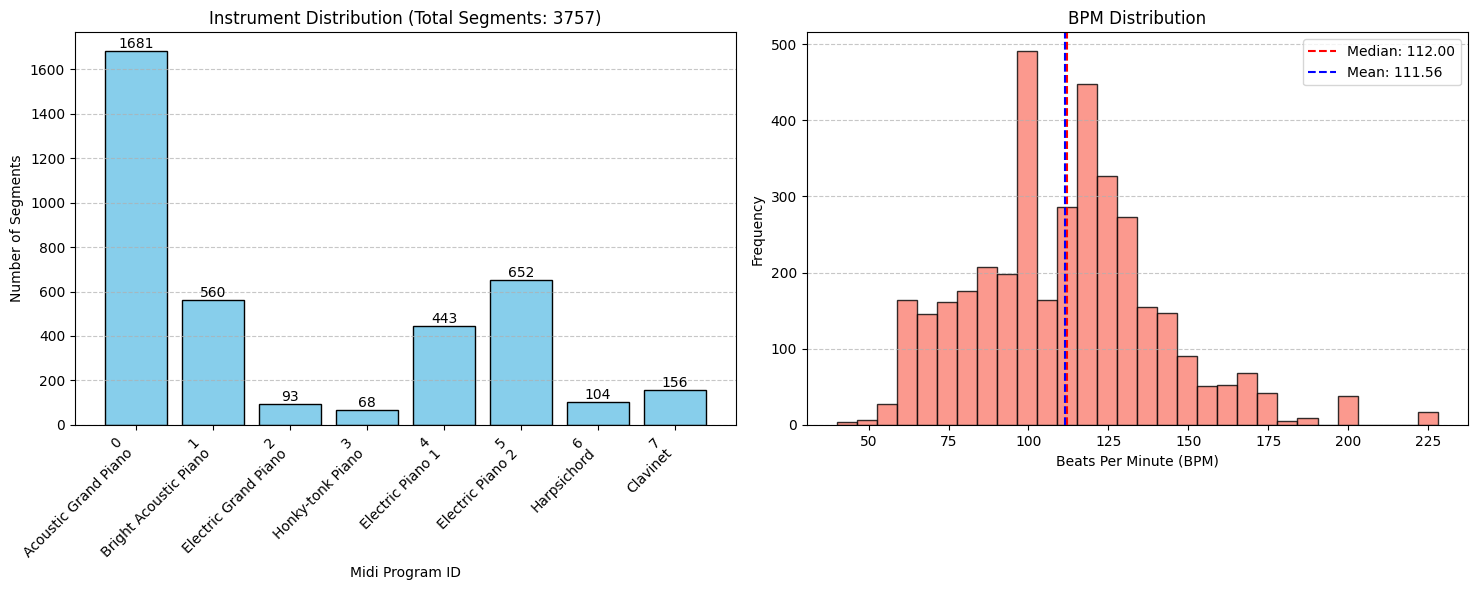

In [10]:
try:
    with open(processing_results_path, 'r') as f:
        for _ in range(20):
            line = f.readline()
            if not line:
                break
            print(line.rstrip())

except FileNotFoundError:
    print(f"File not found: {processing_results_path}")
    
try:
    df_analysis = pd.read_csv(segments_details_path, sep='\t')
    df_analysis = df_analysis.set_index('filename')

    # Extraction data from columns
    instruments = df_analysis['instrument'].values
    bpms = df_analysis['bpm'].values

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # --- Histogram Instruments ---
    instr_counts = Counter(instruments)
    
    # Identify present instruments
    present_instrs = sorted(list(instr_counts.keys()))
    counts = [instr_counts[i] for i in present_instrs]
    # Obtain readable names
    instr_labels = [pretty_midi.program_to_instrument_name(int(i)) for i in present_instrs]
    
    # Display Bars
    bars = ax1.bar([str(i) for i in present_instrs], counts, color='skyblue', edgecolor='black')
    ax1.set_title(f'Instrument Distribution (Total Segments: {len(df_analysis)})')
    ax1.set_xlabel('Midi Program ID')
    ax1.set_ylabel('Number of Segments')
    # Customize x-ticks with instrument names
    ax1.set_xticks(range(len(present_instrs)))
    ax1.set_xticklabels([f"{i}\n{l}" for i, l in zip(present_instrs, instr_labels)], rotation=45, ha='right')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')

    # --- Histogram BPM ---
    ax2.hist(bpms, bins=30, color='salmon', edgecolor='black', alpha=0.8)
    ax2.set_title('BPM Distribution')
    ax2.set_xlabel('Beats Per Minute (BPM)')
    ax2.set_ylabel('Frequency')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Statistics
    median_bpm = np.median(bpms)
    mean_bpm = np.mean(bpms)
    
    ax2.axvline(median_bpm, color='red', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bpm:.2f}')
    ax2.axvline(mean_bpm, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_bpm:.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("ERROR: File not found. Run the saving step first.")

## Load the datasets

In [11]:
def benchmark_loader(loader, num_epochs=1):
    print(f"Start benchmark on {len(loader)} batches for {num_epochs} epochs...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Simulating transfer to: {device}")

    start_time = time.time()
    total_batches = 0
    
    for epoch in range(num_epochs):
        # tqdm gives us a progress bar with real-time speed estimation
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        
        for batch_idx, (prev_bar, curr_bar) in enumerate(pbar):
            # We simulate ONLY the transfer to GPU memory (which has a cost)
            # We do not perform forward/backward pass
            prev_bar = prev_bar.to(device, non_blocking=True)
            curr_bar = curr_bar.to(device, non_blocking=True)
            
            total_batches += 1
            
    end_time = time.time()
    total_time = end_time - start_time
    
    print("\n=== Benchmark Results ===")
    print(f"Total Time: {total_time:.2f} seconds")
    print(f"Batches Processed: {total_batches}")
    print(f"Mean Velocity: {total_batches / total_time:.2f} batch/second")
    print(f"Throughput: {(total_batches * loader.batch_size) / total_time:.2f} samples/second")
    print("===========================")

### New dataset loader using memory mapping

In questo caso ogni sample è una singola coppia (prev_bar, curr_bar) e quindi ogni estrazione è i.i.d.

In [12]:
try:
    with open(processing_results_path, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith("Total segments created:"):
                total_segments = int(line.strip().split(":")[-1])
                break
except FileNotFoundError:
    print(f"File not found: {processing_results_path}")

all_indices = np.arange(total_segments)

# Split indices (80% Train, 10% Val, 10% Test)
train_indices, temp_indices = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, shuffle=True)

print(f"Train Segments: {len(train_indices)}")
print(f"Val Segments:   {len(val_indices)}")
print(f"Test Segments:  {len(test_indices)}")

# Instantiate the Datasets
train_dataset = PianoMmapDataset(mmap_path, split_indices=train_indices, shape=(total_segments, 128, 128))
val_dataset   = PianoMmapDataset(mmap_path, split_indices=val_indices, shape=(total_segments, 128, 128))
test_dataset  = PianoMmapDataset(mmap_path, split_indices=test_indices, shape=(total_segments, 128, 128))

# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=72, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=72, shuffle=False, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=72, shuffle=False, num_workers=0)

# Benchmark the DataLoader
benchmark_loader(train_loader, num_epochs=1)


Train Segments: 3005
Val Segments:   376
Test Segments:  376
Start benchmark on 334 batches for 1 epochs...
Simulating transfer to: cpu


Epoch 1/1:   0%|          | 0/334 [00:00<?, ?batch/s]/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/1: 100%|██████████| 334/334 [00:00<00:00, 369.73batch/s]


=== Benchmark Results ===
Total Time: 0.91 seconds
Batches Processed: 334
Mean Velocity: 368.73 batch/second
Throughput: 26548.50 samples/second


Previous bars shape: torch.Size([72, 1, 128, 16])
Current bars shape: torch.Size([72, 1, 128, 16])


/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/src/utils/visualization.py:29: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


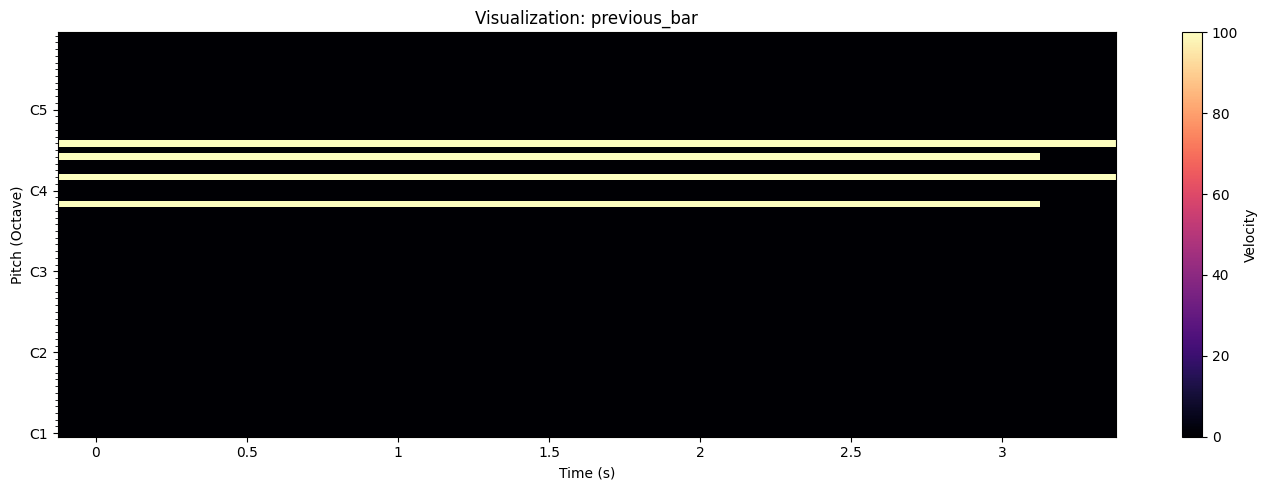

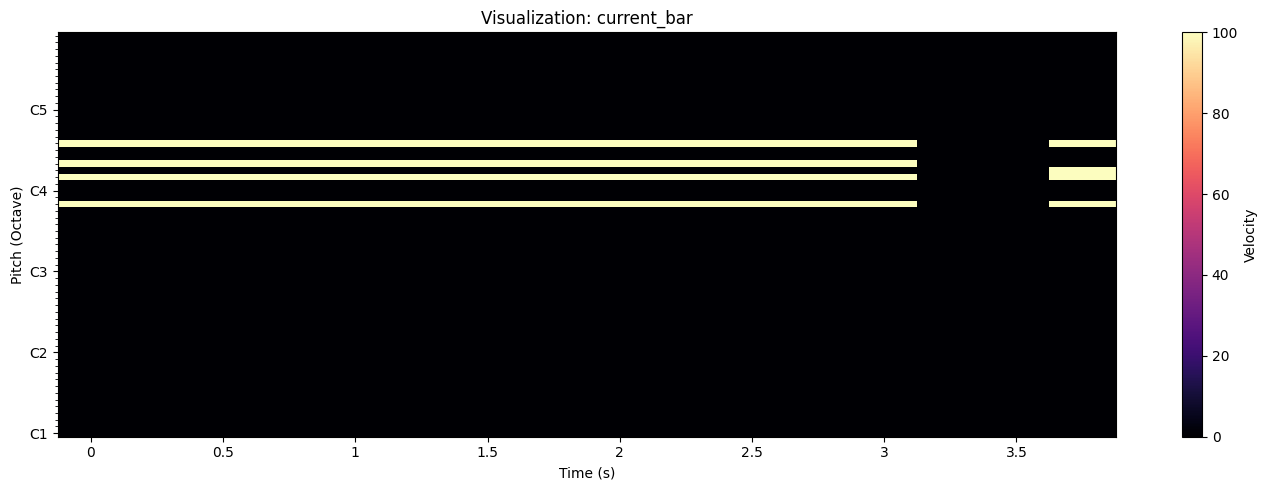

Concatenated bars shape: torch.Size([1, 128, 32])


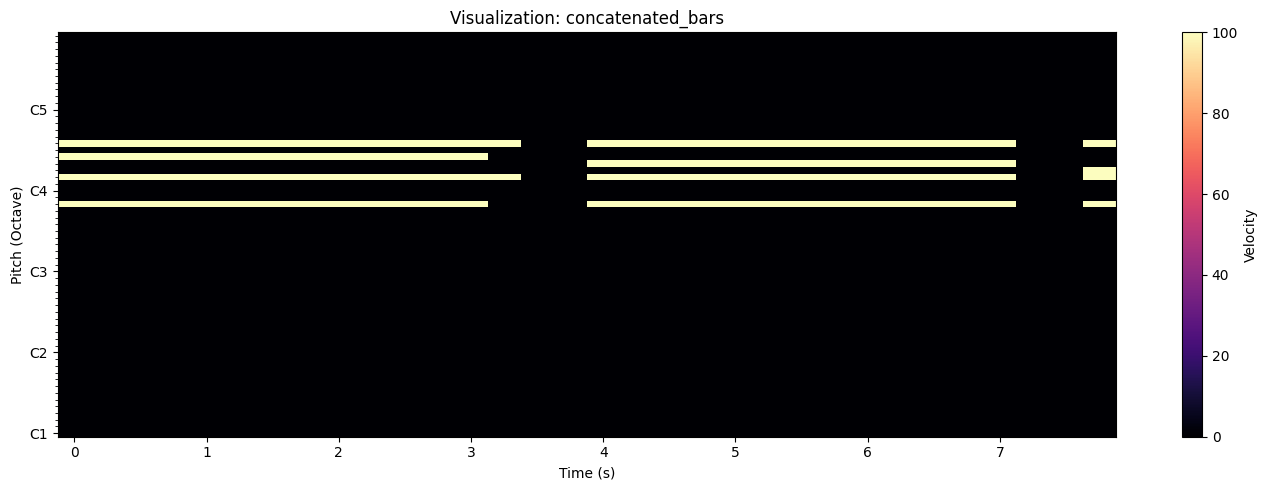

In [13]:
# Visualize a sample from the DataLoader
prev_bar, current_bar = next(iter(train_loader))
print("Previous bars shape:", prev_bar.shape)
print("Current bars shape:", current_bar.shape)

prev_pm = piano_roll_to_pretty_midi(prev_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    prev_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: previous_bar"
)
current_pm = piano_roll_to_pretty_midi(current_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    current_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: current_bar"
)

# Concatenate previous and current bars
concatenated_bars = torch.cat((prev_bar[1], current_bar[1]), dim=2)  # Concatenate along time axis
print("Concatenated bars shape:", concatenated_bars.shape)

concatenated_pm = piano_roll_to_pretty_midi(concatenated_bars.squeeze().numpy()*100, fs=4)
display_prettymidi(
    concatenated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: concatenated_bars"
)

audio = IPython.display.Audio(concatenated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)